This notebook contains code for traning a RandomForest regressor to predict measurement biases of miRXplore datasets from TGIRT-seq.

The [R RandomForest](https://cran.r-project.org/web/packages/randomForest/randomForest.pdf) model is being used here becuase neither [scikit-learn randomforest](https://github.com/scikit-learn/scikit-learn/issues/5442) nor the *train* module from [caret](https://stats.stackexchange.com/questions/135671/how-does-caret-handle-factors) can handle categorically-labeled data.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, train_test_split
import seaborn as sns
from sequencing_tools.viz_tools import color_encoder, simpsons_palette, mixed_sort
from helper_function import *
from feature_selection import make_pca_df, pca_biplot, loading_plot
from rf_modeling import R_randomForest, test_nucleotides, train_to_cat, rename_col
from rpy2.robjects import pandas2ri

plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

/Users/wckdouglas/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Reading in miRNA count data, combining counts from replicates and only look at NTT data, the first and last 3 nucleotides of each miRNA are extracted as predictors, $\Delta log10$ CPM is computed and will be used as target:

In [2]:
df = pd.read_csv('../data/miR_count.csv') \
    .groupby(["prep","seq_id"], as_index=False) \
    .agg({'seq_count':'sum'})\
    .merge(get_seq_base(shuffle = [0,1,2,-3,-2,-1]))\
    .assign(cpm = lambda d: d.groupby('prep').seq_count.transform(count_to_cpm))\
    .assign(expected_cpm = lambda d: 1e6 / 962) \
    .assign(Y = lambda d: np.log10(d['cpm']) - np.log10(d['expected_cpm']))  \
    .query('prep == "NTT"')\
    .reset_index() \
    .drop('index', axis=1)
df.head()

,prep,seq_id,seq_count,head0,head1,head2,tail0,tail1,tail2,cpm,expected_cpm,Y
0,NTT,EBV-1-1,401,T,A,A,G,T,T,11.747525,1039.50104,-1.946879
1,NTT,EBV-1-2,42861,T,A,T,T,G,A,1255.637604,1039.50104,0.082039
2,NTT,EBV-1-2-star,2508,A,A,A,A,G,C,73.473300,1039.50104,-1.150695
3,NTT,EBV-1-3,3964,T,A,A,A,C,A,116.127656,1039.50104,-0.951889
4,NTT,EBV-1-3P,3684,T,A,G,G,T,C,107.924895,1039.50104,-0.983703


In [3]:
model_df = df.filter(regex = 'head|tail|Y') \
    .pipe(train_to_cat)
model_df.head()

/Users/wckdouglas/Google_Drive/Lab/projects/miRNA/tgirt_smRNA/scripts/rf_modeling.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  d[col] = d[col].astype('category')


,head0,head1,head2,tail0,tail1,tail2,Y
0,T,A,A,G,T,T,-1.946879
1,T,A,T,T,G,A,0.082039
2,A,A,A,A,G,C,-1.150695
3,T,A,A,A,C,A,-0.951889
4,T,A,G,G,T,C,-0.983703


# K-fold cross-validation #

20% of the data is partitioned out as test set, other 80% goes into an 8-fold cross-validation

In [4]:
train_df, test_df = train_test_split(model_df, test_size=0.2, random_state=123)

Collect predictions and variable importances from each fold 

In [5]:
rf = R_randomForest()
kf = KFold(n_splits = 8, random_state=123)
res_df = []
var_df = []
for i, (train_idx, test_idx) in enumerate(kf.split(train_df)):
    sub_train_df = train_df.iloc[train_idx,:]
    sub_test_df = train_df.iloc[test_idx]  
    
    X = sub_train_df.drop('Y', axis=1)
    Y = sub_train_df['Y'].values
    rf.fit(X, Y)
    pred = rf.predict(sub_test_df)
    
    var = pandas2ri.ri2py_vector(rf.fitted_rf.rx2('importance')).reshape(-1)
    var_df.append(pd.DataFrame({'imp_score': var,
                        'k' : i,
                        'variable': sub_train_df.drop('Y', axis=1).columns}))
    res_df.append(pd.DataFrame({'pred': pred, 'Y': sub_test_df['Y'], 'k': i}))
    #print(sub_test_df.shape)
res_df = pd.concat(res_df)
var_df = pd.concat(var_df)

/Users/wckdouglas/miniconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)
/Users/wckdouglas/Google_Drive/Lab/projects/miRNA/tgirt_smRNA/scripts/rf_modeling.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  d[col] = d[col].astype('category')
/Users/wckdouglas/Google_Drive/Lab/projects/miRNA/tgirt_smRNA/scripts/rf_modeling.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  test_df['predict'

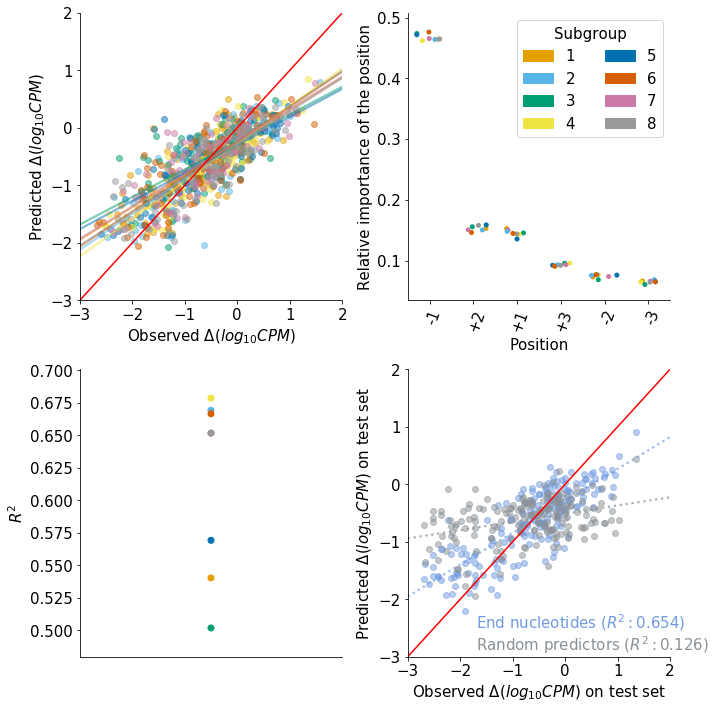

In [6]:
ce = color_encoder()
ce.fit(res_df.k+1)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(221)
scale = np.arange(-3,3)
ax.set_xticks(scale)
ax.set_yticks(scale)
ax.set_xlim(scale[0], scale[-1])
ax.set_ylim(scale[0], scale[-1])
for k, k_df in res_df.groupby('k'):
    sns.regplot(k_df.Y, k_df.pred, 
                label = k + 1, 
                color = ce.encoder[k+1],
                ci = None, 
                truncate=False,
                line_kws = {'alpha': 0.5, 'linestyle':'-'},
                scatter_kws = {'alpha' : 0.5})
ax.plot([-5,3], [-5,3], color='red')
ax.set_xlabel('Observed $\Delta(log_{10} CPM)$')
ax.set_ylabel('Predicted $\Delta(log_{10} CPM)$')

ax.legend().set_visible(False)

    
ax = fig.add_subplot(222)
var_plot_df = var_df\
    .sort_values('imp_score', ascending=False)\
    .assign(variable = lambda d: d.variable.map(rename_col))\
    .assign(imp_score = lambda d: d.groupby('k').imp_score.transform(lambda x: x/x.sum()))
sns.stripplot(data = var_plot_df,
              order = var_plot_df.variable.unique(),
              jitter=0.3,
              y = 'imp_score', 
              x=  'variable', 
              hue = 'k', palette = list(ce.encoder.values()),
              color = 'steelblue', ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, 
                   rotation_mode =  'anchor', ha = 'right')
ax.set_xlabel('Position')
ax.set_ylabel('Relative importance of the position')
lgd = ce.show_legend(ax, title = 'Subgroup', fontsize=15, ncol=2)
lgd.get_title().set_fontsize('15')
    
ax = fig.add_subplot(223)
r2_df = res_df\
    .groupby('k')\
    .apply(lambda d: r2_score(d.Y,d.pred))\
    .transform(pd.DataFrame)\
    .reset_index()\
    .rename(columns={0:'r2'}) \
    .assign(colors = lambda d: d['k'].map(lambda k: ce.encoder[k+1]))
ax.scatter(y = r2_df['r2'], x = r2_df.shape[0] * [1],
         color = r2_df.colors.tolist())
ax.xaxis.set_visible(False)
ax.set_ylabel('$R^2$')


ax = fig.add_subplot(224)
prep_ce = color_encoder()
scale = np.arange(-3,3)
ax.set_xticks(scale)
ax.set_yticks(scale)
ax.set_xlim(scale[0], scale[-1])
ax.set_ylim(scale[0], scale[-1])
## predict on full test_df
random_df = []
t_df = test_nucleotides(nucleotides = [3,4,5, -4,-5,-6], validation=True)
random_df.append(t_df)
t_df, fitted_rf = test_nucleotides(nucleotides=[0,1,2,-3,-2,-1], return_model=True, validation=True)
random_df.append(t_df)
random_df = pd.concat(random_df)
plot_random_df = random_df \
    .groupby('label', as_index=False)\
    .apply(lambda D: pd.DataFrame({'r2':[r2_score(D.Y, D.predict)], 
                                   'label':[D.label.values[0]]})) \
    .merge(random_df) \
    .assign(label = lambda d: d.label + ' ($R^2: ' + d.r2.round(3).astype(str) + '$)')\
    .assign(colors = lambda d: prep_ce.fit_transform(d.label, simpsons_palette()[1:]))

for i, ((label, color), lab_df) in enumerate(plot_random_df.groupby(['label', 'colors'])):
    sns.regplot(data = lab_df, 
            ax = ax,
            color = color,
            x = 'Y', 
            y = 'predict', 
            ci = None,
            scatter_kws={'alpha':0.5},
            line_kws = {'linestyle':':', 'alpha':0.7})
    
    ax.text(-1.7, -2.5 - i/2.5, label, fontsize=15, color = color)
ax.plot([-5,3], [-5,3], color='red')
ax.set_xlabel('Observed $\Delta(log_{10} CPM)$ on test set')
ax.set_ylabel('Predicted $\Delta(log_{10} CPM)$ on test set')
scale = np.arange(-3,3)
ax.set_xticks(scale)
ax.set_yticks(scale)
ax.set_xlim(scale[0], scale[-1])
ax.set_ylim(scale[0], scale[-1])


sns.despine()
fig.tight_layout()
figurename = figure_path + '/rf_cv.pdf'
fig.savefig(figurename, bbox_inches='tight')

figurename = figure_path + '/rf_cv.eps'
fig.savefig(figurename, bbox_inches='tight')

In [7]:
r2_df.describe()

,k,r2
count,8.00000,8.000000
mean,3.50000,0.616224
std,2.44949,0.068490
min,0.00000,0.501864
25%,1.75000,0.562060
50%,3.50000,0.651786
75%,5.25000,0.667328
max,7.00000,0.678712


# Test other nucleotides #

Here, I will use nucleotides other than the first and last 3 bases from each miRNA as predictors and address how random-forest will capture unwanted patterns

In [12]:
random_df = []
t_df = test_nucleotides(nucleotides = [3,4,5, -4,-5,-6])
random_df.append(t_df)
t_df, rf = test_nucleotides(nucleotides=[0,1,2,-3,-2,-1], return_model=True)
random_df.append(t_df)
random_df = pd.concat(random_df)

/Users/wckdouglas/miniconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)
/Users/wckdouglas/Google_Drive/Lab/projects/miRNA/tgirt_smRNA/scripts/rf_modeling.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  d[col] = d[col].astype('category')
/Users/wckdouglas/Google_Drive/Lab/projects/miRNA/tgirt_smRNA/scripts/rf_modeling.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  test_df['predict'

No handles with labels found to put in legend.
No handles with labels found to put in legend.


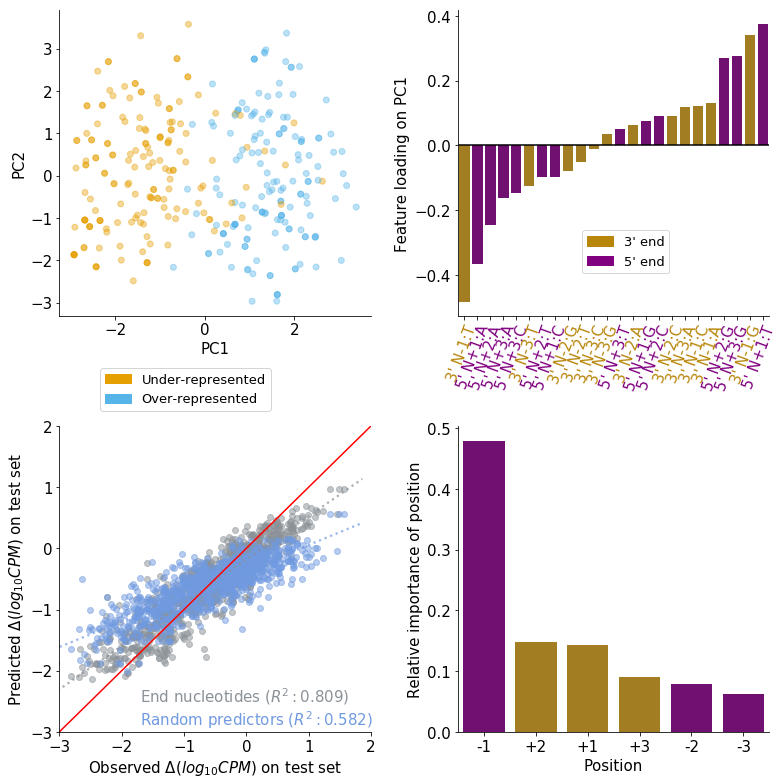

In [13]:
prep_ce = color_encoder()

plot_random_df = random_df \
    .groupby('label', as_index=False)\
    .apply(lambda D: pd.DataFrame({'r2':[r2_score(D.Y, D.predict)], 
                                   'label':[D.label.values[0]]})) \
    .merge(random_df) \
    .assign(label = lambda d: d.label + ' ($R^2: ' + d.r2.round(3).astype(str) + '$)')\
    .assign(colors = lambda d: prep_ce.fit_transform(d.label, simpsons_palette()[1:]))

    
fig = plt.figure(figsize = (11,11))
biplot = fig.add_subplot(221)
pcplot = fig.add_subplot(222)
pca_df = make_pca_df()
pca, pc_df = pca_biplot(pca_df, biplot)
loading_plot(pca_df,pca, pcplot)


ax = fig.add_subplot(223)
for i, ((label, color), lab_df) in enumerate(plot_random_df.groupby(['label', 'colors'])):
    sns.regplot(data = lab_df, 
            ax = ax,
            color = color,
            x = 'Y', 
            y = 'predict', 
            ci = None,
            scatter_kws={'alpha':0.5},
            line_kws = {'linestyle':':', 'alpha':0.7})
    
    ax.text(-1.7, -2.5 - i/2.5, label, fontsize=15, color = color)
ax.plot([-5,3], [-5,3], color='red')
ax.set_xlabel('Observed $\Delta(log_{10} CPM)$ on test set')
ax.set_ylabel('Predicted $\Delta(log_{10} CPM)$ on test set')
scale = np.arange(-3,3)
ax.set_xticks(scale)
ax.set_yticks(scale)
ax.set_xlim(scale[0], scale[-1])
ax.set_ylim(scale[0], scale[-1])



ax = fig.add_subplot(224)
var_df = pd.DataFrame({'imp_score':pandas2ri.ri2py_floatvector(rf.fitted_rf.rx2('importance')).reshape(-1),
                      'x': train_df.drop('Y', axis=1).columns }) \
    .sort_values('imp_score', ascending=False)\
    .assign(imp_score = lambda d: d.imp_score/d.imp_score.sum())\
    .assign(x = lambda d: d.x.map(rename_col))\
    .assign(color = lambda d: np.where(d.x.str.contains('-'), 'purple', 'darkgoldenrod'))
sns.barplot(data = var_df, x = 'x', y = 'imp_score', 
            ax = ax, order = var_df['x'],
            palette = var_df.color.tolist())
ax.legend().set_visible(False)
ax.set_xlabel('Position')
ax.set_ylabel('Relative importance of position')

fig.tight_layout()
sns.despine()
figurename = figure_path + '/rf_control.pdf'
fig.savefig(figurename, bbox_inches='tight')
figurename = figure_path + '/rf_control.eps'
fig.savefig(figurename, bbox_inches='tight')

In [14]:
var_df.groupby('color').agg({'imp_score':'sum'})

,imp_score
color,
darkgoldenrod,0.380328
purple,0.619672


/Users/wckdouglas/miniconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)
/Users/wckdouglas/Google_Drive/Lab/projects/miRNA/tgirt_smRNA/scripts/rf_modeling.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  d[col] = d[col].astype('category')
/Users/wckdouglas/Google_Drive/Lab/projects/miRNA/tgirt_smRNA/scripts/rf_modeling.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  test_df['predict'

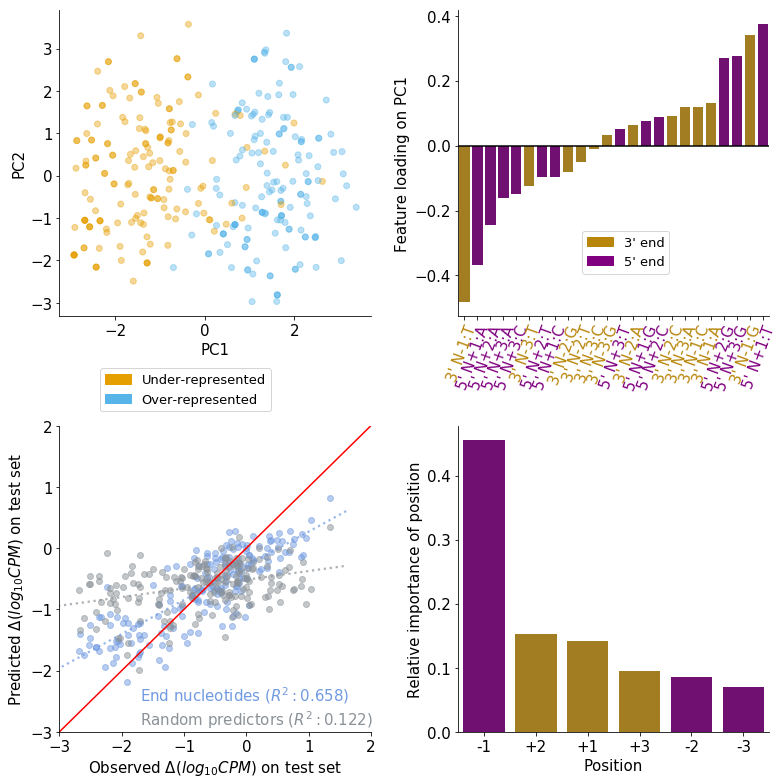

In [17]:
random_df = []
t_df = test_nucleotides(nucleotides = [3,4,5, -4,-5,-6], validation=True)
random_df.append(t_df)
t_df, rf = test_nucleotides(nucleotides=[0,1,2,-3,-2,-1], return_model=True, validation=True)
random_df.append(t_df)
random_df = pd.concat(random_df)


#
plot_random_df = random_df \
    .groupby('label', as_index=False)\
    .apply(lambda D: pd.DataFrame({'r2':[r2_score(D.Y, D.predict)], 
                                   'label':[D.label.values[0]]})) \
    .merge(random_df) \
    .assign(label = lambda d: d.label + ' ($R^2: ' + d.r2.round(3).astype(str) + '$)')\
    .assign(colors = lambda d: prep_ce.fit_transform(d.label, simpsons_palette()[1:]))

    
fig = plt.figure(figsize = (11,11))
biplot = fig.add_subplot(221)
pcplot = fig.add_subplot(222)
pca_df = make_pca_df()
pca, pc_df = pca_biplot(pca_df, biplot)
loading_plot(pca_df,pca, pcplot)


ax = fig.add_subplot(223)
for i, ((label, color), lab_df) in enumerate(plot_random_df.groupby(['label', 'colors'])):
    sns.regplot(data = lab_df, 
            ax = ax,
            color = color,
            x = 'Y', 
            y = 'predict', 
            ci = None,
            scatter_kws={'alpha':0.5},
            line_kws = {'linestyle':':', 'alpha':0.7})
    
    ax.text(-1.7, -2.5 - i/2.5, label, fontsize=15, color = color)
ax.plot([-5,3], [-5,3], color='red')
ax.set_xlabel('Observed $\Delta(log_{10} CPM)$ on test set')
ax.set_ylabel('Predicted $\Delta(log_{10} CPM)$ on test set')
scale = np.arange(-3,3)
ax.set_xticks(scale)
ax.set_yticks(scale)
ax.set_xlim(scale[0], scale[-1])
ax.set_ylim(scale[0], scale[-1])



ax = fig.add_subplot(224)
var_df = pd.DataFrame({'imp_score':pandas2ri.ri2py_floatvector(rf.fitted_rf.rx2('importance')).reshape(-1),
                      'x': train_df.drop('Y', axis=1).columns }) \
    .sort_values('imp_score', ascending=False)\
    .assign(imp_score = lambda d: d.imp_score/d.imp_score.sum())\
    .assign(x = lambda d: d.x.map(rename_col))\
    .assign(color = lambda d: np.where(d.x.str.contains('-'), 'purple', 'darkgoldenrod'))
sns.barplot(data = var_df, x = 'x', y = 'imp_score', 
            ax = ax, order = var_df['x'],
            palette = var_df.color.tolist())
ax.legend().set_visible(False)
ax.set_xlabel('Position')
ax.set_ylabel('Relative importance of position')

fig.tight_layout()
sns.despine()

# Corrections #

Training the model on combined NTT dataset, and apply the model on other samples

In [ ]:
df = pd.read_feather('../data/miR_count.feather')  \
    .merge(get_seq_base(shuffle = [0,1,2,-3,-2,-1])) 
df.head()

In [ ]:
train_df =  df.groupby(["prep","seq_id"], as_index=False) \
    .agg({'seq_count':'sum'})\
    .merge(get_seq_base(shuffle = [0,1,2,-3,-2,-1]))\
    .assign(cpm = lambda d: d.groupby('prep').seq_count.transform(count_to_cpm))\
    .assign(expected_cpm = lambda d: 1e6 / 962) \
    .assign(Y = lambda d: np.log10(d['cpm']) - np.log10(d['expected_cpm']))  \
    .query('prep == "NTT"')\
    .reset_index() \
    .filter(regex='head|tail|Y') \
    .pipe(train_to_cat)
train_df.head()

In [ ]:
r_train_df = pandas2ri.DataFrame(train_df)
formula = Formula('Y~.')
final_model = rf.randomForest(formula = formula, data = r_train_df)

coef_df = train_df\
    .drop('Y', axis=1)\
    .drop_duplicates()
coef_df['predicted'] = pandas2ri.ri2py_vector(stats.predict(final_model, pandas2ri.DataFrame(coef_df)))
coef_df.head()

In [ ]:
train_df.shape

In [ ]:
corrected_df = df \
    .merge(coef_df)\
    .assign(log10_cpm = lambda d: np.log10(d.cpm))\
    .assign(pseudocount = lambda d: np.power(10, d.log10_cpm - d.predicted)) \
    .filter(regex='seq|sample|count|prep')\
    .pipe(pd.melt, id_vars = ['seq_id','prep','samplename'], var_name = 'count_type', value_name = 'seq_count') \
    .query('count_type != "seq_count"')\
    .assign(samplename = lambda d: d.samplename + ' (Corrected)')\
    .assign(prep = lambda d: d.prep + ' (Corrected)')\
    .drop('count_type', axis=1) \
    .reset_index()
corrected_df.to_feather('corrected_count.feather')
corrected_df.head()